In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Part 3: Classification model with PyTorch


**HINTS**
- Choose a loss function that is suitable for the specific problem, a binary classification in this case. If you keep a single linear output you can use a BCEWithLogitsLoss, which is more numerically stable than manually using a sigmoid output activation (more info here: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html ).
- The network now has 2 inputs. A batched input should have a shape $\text{batch_size} \times 2$.
- The dataset should be adapted accordingly. Also consider to increase the batch size.
- Explore different optimizers, trying to understand the differences and their parameters (https://pytorch.org/docs/stable/optim.html ).
- Try to increase the complexity of the network, and at the same time to introduce some regularization with dropout layers and/or weight decay (which is equivalent to an L2 regularization, typically implemented by the optimizer).
- Experiment with different hyper-parameters trying to minimize the VALIDATION LOSS. Once you are happy with the result, try the final test with the TEST dataset.

## Data generation

/tmp/ipykernel_9183/2858483818.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


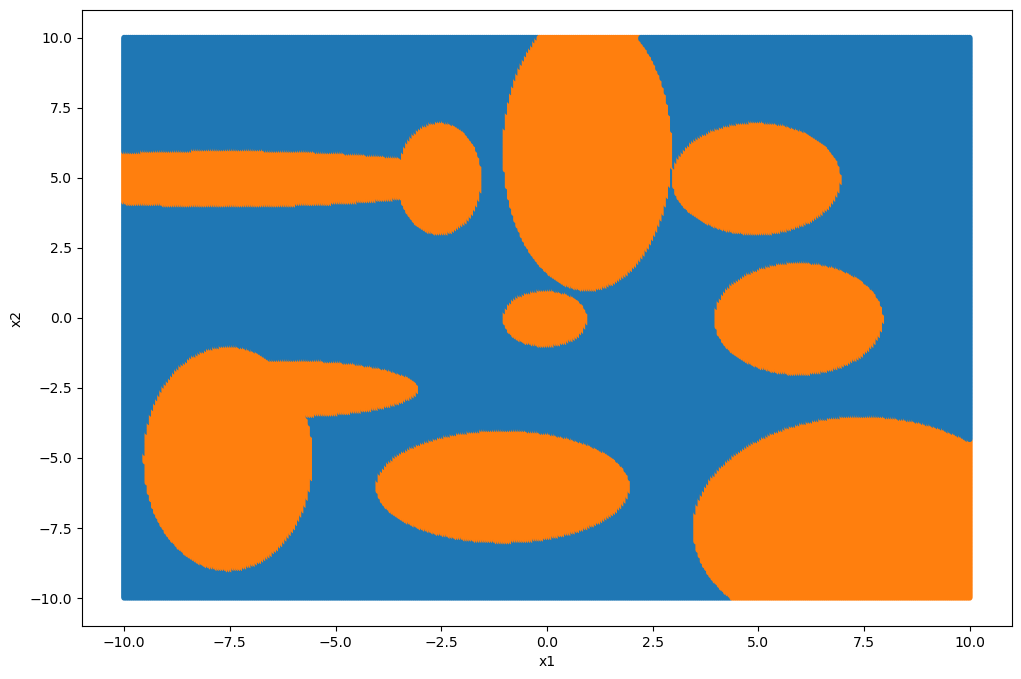

In [2]:
import itertools

np.random.seed(123)

def bidimensional_model(x1, x2):
    a = 1
    b = 1
    cx1 = 0
    cx2 = 0
    out = (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 2
    cx1 = 5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 1
    b = 2
    cx1 = -2.5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 3
    b = 1
    cx1 = -6
    cx2 = -2.5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 4
    cx1 = -7.5
    cx2 = -5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 6
    b = 1
    cx1 = -7.5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 4
    b = 4
    cx1 = 7.5
    cx2 = -7.5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 3
    b = 2
    cx1 = -1
    cx2 = -6
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 5
    cx1 = 1
    cx2 = 6
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 2
    cx1 = 6
    cx2 = 0
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    return out.astype(int)

### PLOT MODEL
# Input grid
x1 = np.linspace(-10, 10, 400)
x2 = np.linspace(-10, 10, 400)
x_prod = [x for x in itertools.product(x1, x2)]
x1 = np.array([x[0] for x in x_prod])
x2 = np.array([x[1] for x in x_prod])
# Evaluate out
y = bidimensional_model(x1, x2)
# Scatter plot
fig, ax = plt.subplots(figsize=(12,8))
colors = np.array(['C0', 'C1'])
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.show()

### Training points

/tmp/ipykernel_9183/764034644.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


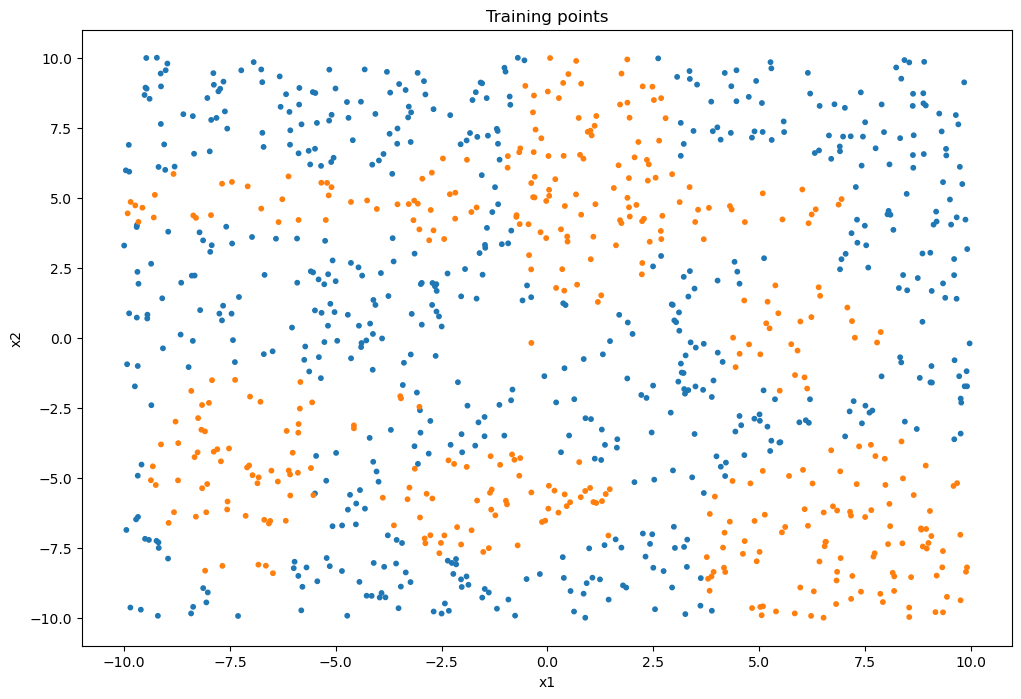

In [3]:
import pandas as pd

### Train data
num_points = 1000
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
train_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
train_df.to_csv('classifier_train_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Training points')
fig.show()

### Validation points

In this case: we generate validation points.
Usually: validation points are randomly selected from the training points (~20% of training data).

/tmp/ipykernel_9183/286216996.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


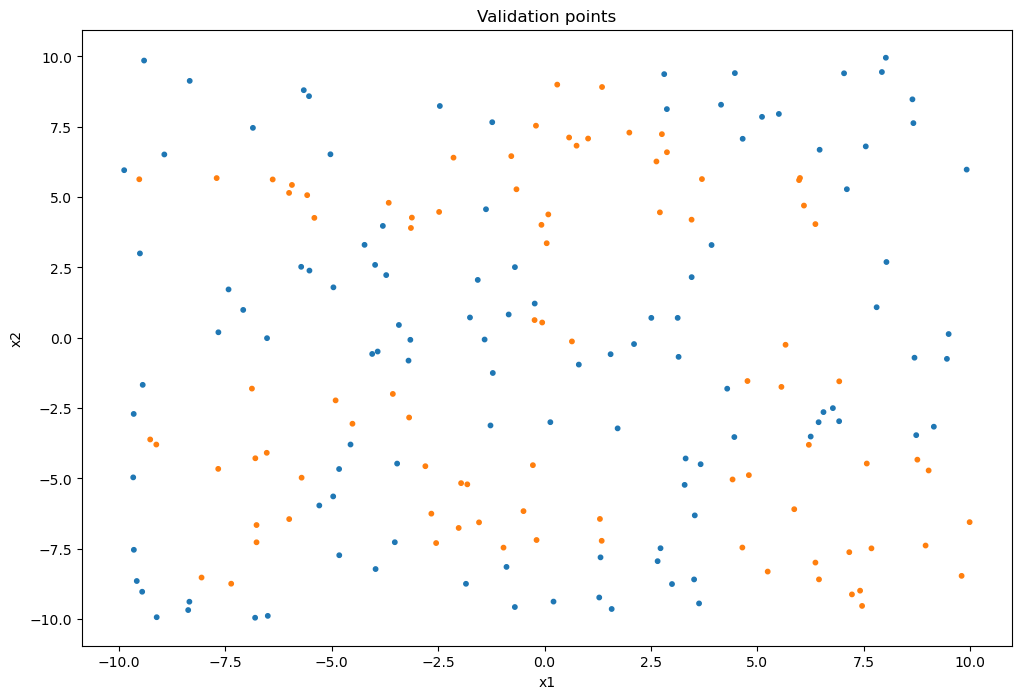

In [4]:
### Validation data
num_points = 200
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_val_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Validation points')
fig.show()

### Test points

/tmp/ipykernel_9183/2542151212.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


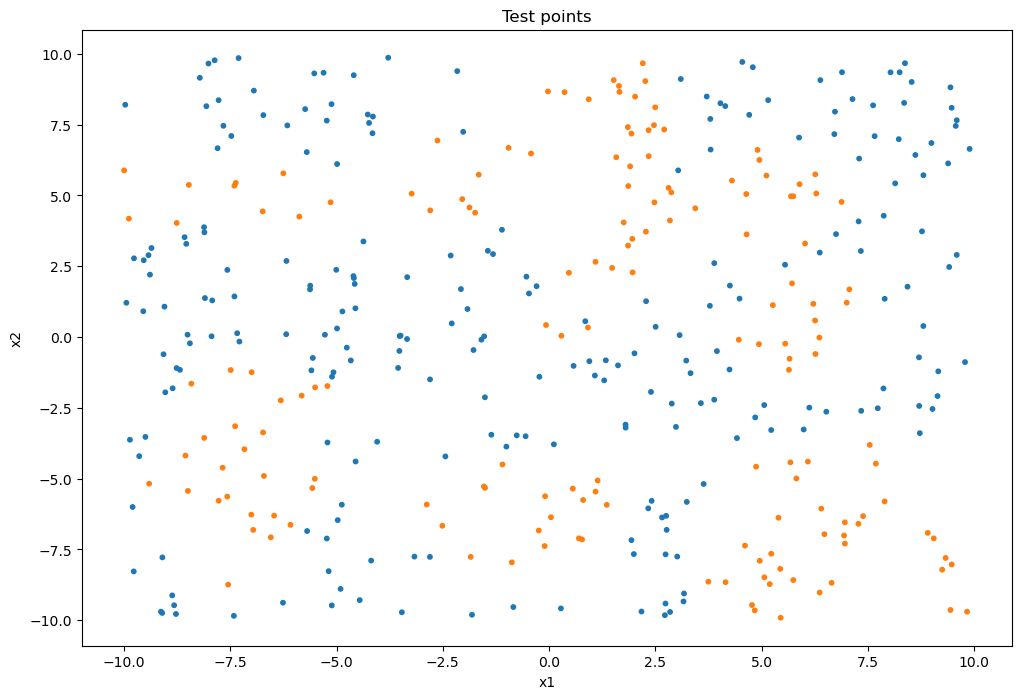

In [5]:
### Test data
num_points = 400
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_test_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Test points')
fig.show()

## Dataset and Dataloader

Define the dataset

In [6]:
class ClassifierDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and store the content in a pandas DataFrame
        self.df = pd.read_csv(csv_file, sep=',')

    def __len__(self):
        # The length of the dataset is simply the length of the self.df DataFrame
        return len(self.df)

    def __getitem__(self, idx):
        # Our sample is the row at index idx of the dataframe
        row = self.df.iloc[idx]
        # There are 2 inputs this time
        if row.y:
            sample = ([row.x1, row.x2], [row.y, 0])
        else:
            sample = ([row.x1, row.x2], [row.y, 1])
        if self.transform:
            sample = self.transform(sample)
        return sample

Define the transformations

In [7]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor(x).float(),
                torch.Tensor(y).float())

Initialize the datasets

In [8]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = ClassifierDataset("classifier_train_data.csv", transform=composed_transform)
val_dataset = ClassifierDataset("classifier_val_data.csv", transform=composed_transform)
test_dataset = ClassifierDataset("classifier_test_data.csv", transform=composed_transform)
print(train_dataset[1])

(tensor([-4.2772, -0.0992]), tensor([0., 1.]))


Define the dataloaders

In [9]:
###############################
#Put your code here
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
###############################

## Network definition

In [10]:
class Net(nn.Module):

    def __init__(self, Ni, Nh1, Nh2, Nh3, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()

        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        self.dropout = nn.Dropout(0.5)
        self.act = nn.ReLU()

    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.act(self.fc3(x))
        x = self.dropout(x)
        x = self.out(x)
        return x.softmax(dim=1)

## Training loop

In [11]:
# Initialize the network
torch.manual_seed(0)
Ni = 2
Nh1 = 256
Nh2 = 256
Nh3 = 256
No = 2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

net = Net(Ni, Nh1, Nh2, Nh3, No)
net.to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss() # TODO: use a proper classification loss

# Define the optimizer with lr=1e-3
#optimizer = optim.SGD(net.parameters(), lr=1e-3, weight_decay=0, momentum=0.9, nesterov=True)
optimizer = optim.Adam(net.parameters(), lr=1e-1)

Training device: cpu
Network initialized


In [12]:
### TRAINING LOOP
num_epochs = 1000
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    if not epoch_num % 100:
        print('#################')
        print(f'# EPOCH {epoch_num}')
        print('#################')

    ### TRAIN
    train_loss= []
    ###############################################
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Zero your gradients for every batch
        net.zero_grad()

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    if not epoch_num % 100:
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
        ###############################################
        # Save average validation loss
        val_loss = np.mean(val_loss)
        if not epoch_num % 100:
            print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_loss_log.append(val_loss)


#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.7205878496170044
AVERAGE VAL LOSS: 0.7582616209983826
#################
# EPOCH 100
#################
AVERAGE TRAIN LOSS: 0.7212616205215454
AVERAGE VAL LOSS: 0.7582617402076721
#################
# EPOCH 200
#################
AVERAGE TRAIN LOSS: 0.7212616205215454
AVERAGE VAL LOSS: 0.7582615613937378
#################
# EPOCH 300
#################
AVERAGE TRAIN LOSS: 0.7212616801261902
AVERAGE VAL LOSS: 0.7582615613937378
#################
# EPOCH 400
#################
AVERAGE TRAIN LOSS: 0.7212616205215454
AVERAGE VAL LOSS: 0.7582616209983826
#################
# EPOCH 500
#################
AVERAGE TRAIN LOSS: 0.7212616205215454
AVERAGE VAL LOSS: 0.7582615613937378
#################
# EPOCH 600
#################
AVERAGE TRAIN LOSS: 0.7212616205215454
AVERAGE VAL LOSS: 0.7582616209983826
#################
# EPOCH 700
#################
AVERAGE TRAIN LOSS: 0.7212616205215454
AVERAGE VAL LOSS: 0.7582616209983826
##########

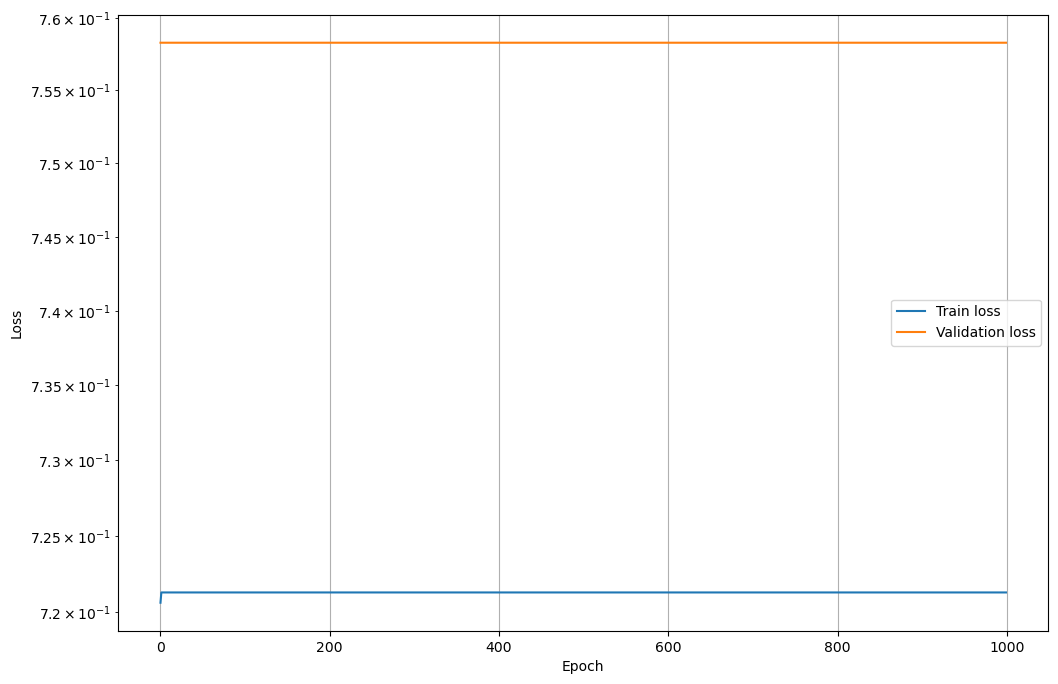

In [13]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Final test

Iterate the dataloader a single time and save all the outputs (in case you have multiple batches)

In [14]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = net(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.7132617235183716


In this case the network has a linear output (for a better stability of the loss function).
To have probability estimates you can apply a sigmoid to the network output.

Since we just need the most probable class and we have a single output, we can consider the sign of the linear output. Negative output means that the class 0 is the most probable (probability < 50%), otherwise class 1 (probability > 50%).

Essentially this network estimates the probability of the input sample to be of class 1.

> **NOTE**
>
> You can (and should, for practice) redefine the problem by defining a network with more than one output, each of them corresponding to a specific class (2 in this case). Since the two classes are mutually exclusive, the loss function should be a CrossEntropyLoss (softmax activation). In a multi-class scenario, a BCE loss is suitable when the classes are NOT mutually exclusive.






---


Get the most probable class inferred by the network


In [15]:
# Get the most probable class inferred by the network
all_output_classes = torch.zeros(all_outputs.shape).to(device)
for i, out in enumerate(all_outputs):
    all_output_classes[i][torch.argmax(out)] = 1

Evaluate the test accuracy

In [16]:
print(all_labels.shape)
print(all_output_classes.shape)
tot_correct_out = (all_output_classes[:, 0] == all_labels[:, 0]).sum()
#tot_correct_out = 0
#for a, b in zip(all_output_classes, all_labels):
#    print(a, b)
#    if a[0] == b[0]:
#        tot_correct_out += 1
#print(tot_correct_out)
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

torch.Size([400, 2])
torch.Size([400, 2])
TEST ACCURACY: 60.00%


In [17]:
len(all_output_classes)

400

Plot the results

/tmp/ipykernel_9183/688618880.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


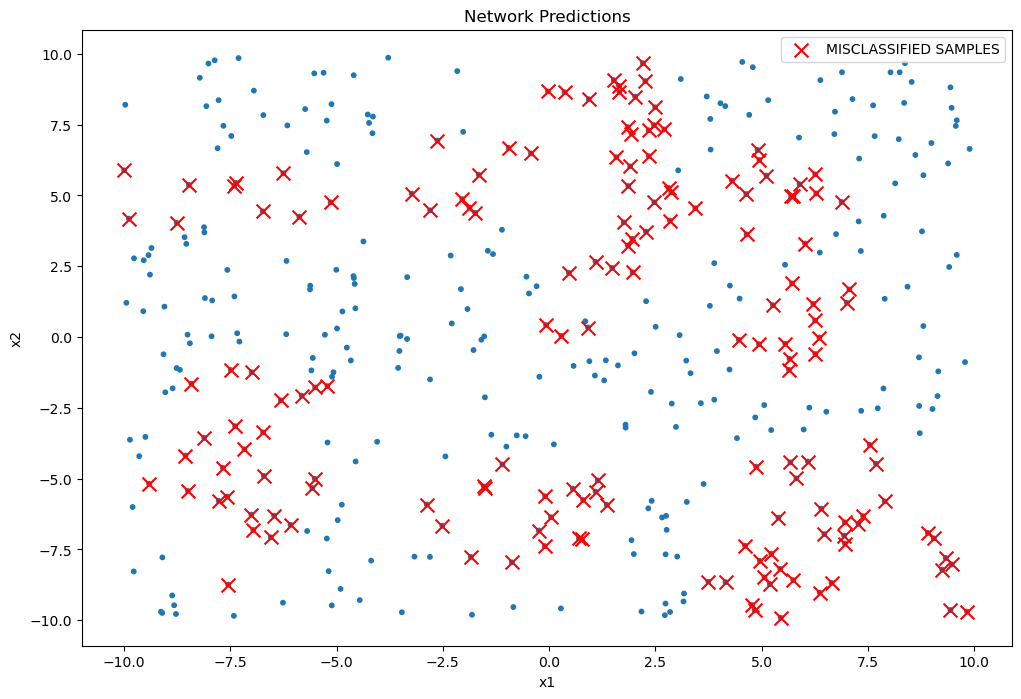

In [18]:
### Plot
x1 = all_inputs.squeeze().cpu().numpy()[:, 0]
x2 = all_inputs.squeeze().cpu().numpy()[:, 1]
y_true = all_labels.squeeze().cpu().numpy()[:, 0]
y_pred = all_output_classes.squeeze().cpu().numpy()[:, 0]

fig, ax = plt.subplots(figsize=(12,8))
# Plot predictions
ax.scatter(x1, x2, c=colors[y_pred.astype(np.uint8)], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Network Predictions')
# Mark wrong outputs
error_mask = y_pred != y_true
ax.scatter(x1[error_mask], x2[error_mask], color='red', s=100, marker='x', label='MISCLASSIFIED SAMPLES')
plt.legend()
fig.show()

# (Optional) High-level and Lightweight PyTorch wrapper: PyTorch Lightning


Lightning forces the following structure to your code which makes it reusable and shareable:

Research code (the LightningModule).
Engineering code (you delete, and is handled by the Trainer).
Non-essential research code (logging, etc... this goes in Callbacks).
Data (use PyTorch DataLoaders or organize them into a LightningDataModule).
Once you do this, you can train on multiple-GPUs, TPUs, CPUs and even in 16-bit precision without changing your code!

In [19]:
#! pip install pytorch-lightning

import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

ModuleNotFoundError: No module named 'pytorch_lightning'

In [ ]:
# Define a LightningModule (nn.Module subclass)
# A LightningModule defines a full system (ie: a GAN, autoencoder, BERT or a simple Image Classifier).
class LitNet(pl.LightningModule):
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()

        print('Network initialized')
        self.net = nn.Sequential(nn.Linear(in_features=Ni, out_features=Nh1),
                       nn.Sigmoid(),
                       nn.Linear(in_features=Nh1, out_features=Nh2),
                       nn.Sigmoid(),
                       nn.Linear(in_features=Nh2, out_features=No))
        self.val_loss = []
        self.train_loss = []

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        return self.net(x)

    # Training_step defines the training loop.
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.binary_cross_entropy_with_logits(out, label_batch)
        self.train_loss.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx=None):
        # validation_step defines the validation loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.binary_cross_entropy_with_logits(out, label_batch)
        self.val_loss.append(loss.item())
        self.log("val_loss", loss.item(), prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(), lr=1e-2)
        return optimizer

In [ ]:
# TRAIN!
batch_size = 50
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

trainer = pl.Trainer(devices=1, max_epochs=30, val_check_interval=1)
litnet = LitNet(Ni, Nh1, Nh2, No)
trainer.fit(litnet, train_dataloader, val_dataloader)


In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(litnet.train_loss, label='Train loss')
plt.semilogy(litnet.val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# (Optional) Automatic Hyper-parameters Tuning: Optuna


Optuna is an automatic hyperparameter optimization software framework.

- Lightweight, versatile, and platform agnostic architecture
- Pythonic search spaces
- Efficient optimization algorithms
- Easy parallelization
- Quick visualization


Definitions:

- Study: optimization based on an objective function
- Trial: a single execution of the objective function

The goal of a study is to find out the optimal set of hyperparameter values (e.g., classifier and svm_c) through multiple trials (e.g., n_trials=100). Optuna is a framework designed for the automation and the acceleration of the optimization studies.

Optuna works with PyTorch, but also with Tensorflow, Keras and PyTorch Lightning! (and many others)

In [ ]:
! pip install optuna

In [ ]:
# Before we used:
# Nh1 = 128
# Nh2 = 256

import optuna

def objective(trial):

    # We optimize the number of hidden units in each layer.
    output_dims = [
        trial.suggest_int("n_units_l{}".format(i), 64, 256, log=True) for i in range(2)
    ]

    model = LitNet(Ni, output_dims[0], output_dims[1], No)

    trainer = pl.Trainer(devices=1, max_epochs=20, val_check_interval=1,
                         log_every_n_steps=1)
    hyperparameters = dict(output_dims=output_dims)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, train_dataloader, val_dataloader)
    return trainer.callback_metrics["val_loss"].item()


pruner = optuna.pruners.NopPruner()
# print(pruner) <optuna.pruners._nop.NopPruner object at 0x7f4c2466ed50>
# print(type(pruner)) <class 'optuna.pruners._nop.NopPruner'>

study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=3, timeout=300)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Homework

Try tuning other hyper-parameters, such as the learning rate.